# **Task 6: Combining Convolution and Self-attention**
Consider the following scenario where input to a model with only single layer, is denoted as X. For the following
operations, we have provided a general idea about each operation and have left the understanding of sizes of
images/patches/vectors etc., to you: </br>

* Analyze the mathematical structure of the operations and describe how information is propagated
from neighboring pixels in each case.

*   For each operation, understand how the receptive field at any given pixel i, considering the differences between
convolution, self-attention, and their combinations.
*   Create different models, each based on one of the operations, Each model will consist
of a single layer implementing the operations for feature extraction. Visualize the feature maps produced
by each operation. Pick a sample image from any useful dataset, and generate feature maps after applying
each operation to see how different parts of the image are emphasized. For the models with self-attention
components, visualize the attention maps to understand how global dependencies are captured.





# **Loading a Single Image and Visualizing It**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install pillow

In [6]:
import numpy as np
import torch
import torchvision.transforms as transforms
import PIL as Image
from PIL.Image import open

transform = transforms.Compose([transforms.Resize((int(524/4), int(720/4))),transforms.ToTensor()])
img = open('/content/drive/MyDrive/Advanced_ML/PA1/image_task6.jpg')
tensor = transform(img)
print(tensor.shape)


torch.Size([3, 131, 180])


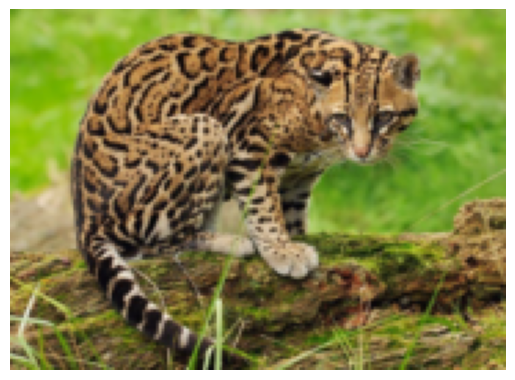

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_image(image_tensor):
    image_np = image_tensor.detach().cpu().numpy()

    # Rearrange the dimensions to [height, width, channels]
    image_np = image_np.transpose(1, 2, 0)

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()


visualize_image(tensor)

# **Depthwise Convolution**

In [15]:
import torch
import torch.nn as nn

class DepthwiseConv(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1):
        super(DepthwiseConv, self).__init__()

        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            padding=kernel_size//2,
            stride=stride
        )

    def forward(self, x):
        out = self.depthwise_conv(x)
        return out


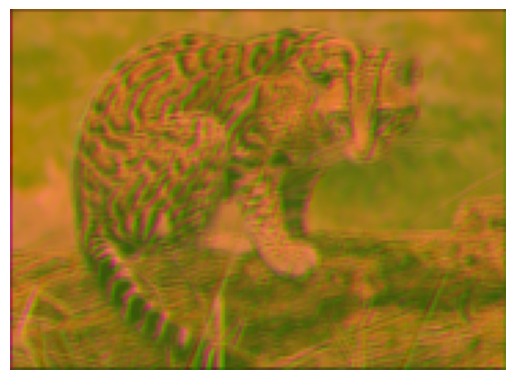

In [16]:
depthwise_conv_layer = DepthwiseConv(3,3)
output= depthwise_conv_layer(tensor)
visualize_image(output)

# **Self Attention**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.norm = nn.BatchNorm2d(in_channels)
        # self.act = nn.Tanh()

    # Input shape: (channels, height, width)
    def forward(self, x):
        # Add batch dimension: (1, channels, height, width)
        x = x.unsqueeze(0)  # Assuming x has no batch dimension

        Q = self.query(x)  # (1, channels, height, width)
        K = self.key(x)    # (1, channels, height, width)
        V = self.value(x)  # (1, channels, height, width)

        batch, channels, height, width = Q.size()
        N = height * width  # Sequence length

        # Reshape for matrix multiplication
        Q = Q.view(batch, channels, N)          # (1, channels, N)
        K = K.view(batch, channels, N)          # (1, channels, N)
        V = V.view(batch, channels, N)          # (1, channels, N)

        # Transpose Q for multiplication
        Q = Q.permute(0, 2, 1)                   # (1, N, channels)
        K = K                                    # (1, channels, N)

        # Compute attention scores
        attention = torch.bmm(Q, K)             # (1, N, N)
        attention_scores = F.softmax(attention, dim=-1)  # (1, N, N)

        # Multiply attention scores with V
        V = V.permute(0, 2, 1)                   # (1, N, channels)
        out = torch.bmm(attention_scores, V)    # (1, N, channels)

        # Reshape back to (channels, height, width)
        out = out.permute(0, 2, 1).contiguous()  # (1, channels, N)
        out = out.view(batch, channels, height, width)  # (1, channels, height, width)
         # Normalize and activate
        out = self.norm(out)
        # out = self.act(out)

        # Remove batch dimension
        out = out.squeeze(0)
        return out



Output shape: torch.Size([3, 131, 180])


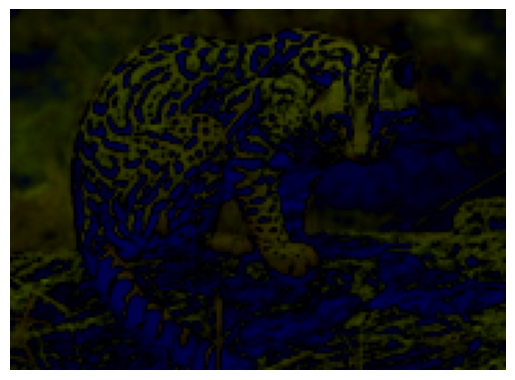

In [18]:
self_att = SelfAttention(in_channels=3)

    # images = images.squeeze(0)
output_tensor = self_att(tensor)
print(f"Output shape: {output_tensor.shape}")

# visualize_attention(output_tensor,channel='average')
visualize_image(output_tensor)